In [1]:
import pandas as pd
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
from scxmatch import test
import scanpy as sc

will use the CPU to calculate the distance matrix.


In [2]:
stimuli = ['Ctrl', 'MCSF', 'TGFbeta', 'LPS', 'IFN10', 'YM201636']

In [3]:
data = pd.read_csv("../evaluation_results/4_miriam/single_cell_features.csv").drop(["Unnamed: 0"], axis=1)
adata = ad.AnnData(data.iloc[:, :-1], obs=pd.DataFrame(data["Label"]))
adata = adata[np.isin(adata.obs, stimuli)].copy()

static_features = ["Mean area", "Mean perimeter", 'Mean soli.', 'Mean conv.', 'Mean circ.', 'Mean asp. ratio', 'Mean protr.', 'Mean angul.']
static_adata = ad.AnnData(data[static_features], obs=pd.DataFrame(data["Label"]))
static_adata = static_adata[np.isin(static_adata.obs, stimuli)].copy()

#all_features = pd.read_csv("../evaluation_results/4_miriam/31D_All.csv").set_index("Unnamed: 0").loc[stimuli, stimuli]
#static_features = pd.read_csv("../evaluation_results/4_miriam/8D_PurelyStatic.csv").set_index("Unnamed: 0").loc[stimuli, stimuli]

/data/bionets/je30bery/conda/envs/xm/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/data/bionets/je30bery/conda/envs/xm/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
p_values = pd.DataFrame(np.zeros((len(stimuli), len(stimuli))), index=stimuli, columns=stimuli)
p_values_static = pd.DataFrame(np.zeros((len(stimuli), len(stimuli))), index=stimuli, columns=stimuli)

In [5]:
for i, stim1 in enumerate(stimuli):
    for j, stim2 in enumerate(stimuli):
        if j < i:
            p_values.loc[stim1, stim2], _, _ = test(adata, group_by="Label", reference=stim1, test_group=stim2, metric="seuclidean", rank=False, k="full")
            p_values_static.loc[stim1, stim2], _, _ = test(static_adata, group_by="Label", reference=stim1, test_group=stim2, metric="seuclidean", rank=False, k="full")

using CPU to calculate distance matrix.
creating distance graph with 182 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 182 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 178 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 178 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 110 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 110 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 156 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 156 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distance graph with 90 samples
counting cross matches.
using CPU to calculate distance matrix.
creating distanc

In [6]:
p_values.values[np.where(p_values.values > 0)] = multipletests(p_values.values[np.where(p_values.values > 0)], method="fdr_bh")[1]

In [7]:
p_values_static.values[np.where(p_values_static.values > 0)] = multipletests(p_values_static.values[np.where(p_values_static.values > 0)], method="fdr_bh")[1]

In [8]:
all_features = p_values + p_values_static.T

In [9]:
mask = np.eye(len(all_features.values))

In [10]:
sc.pp.neighbors(adata)
sc.pp.neighbors(static_adata)
sc.tl.umap(adata)
sc.tl.umap(static_adata)

In [11]:
scatter_df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP 1 all features", "UMAP 2 all features"])
scatter_df[["UMAP 1 static features", "UMAP 2 static features"]] = static_adata.obsm["X_umap"]
scatter_df["Group"] = adata.obs["Label"].values
scatter_df = scatter_df[scatter_df["Group"].isin(["Ctrl", "MCSF"])]

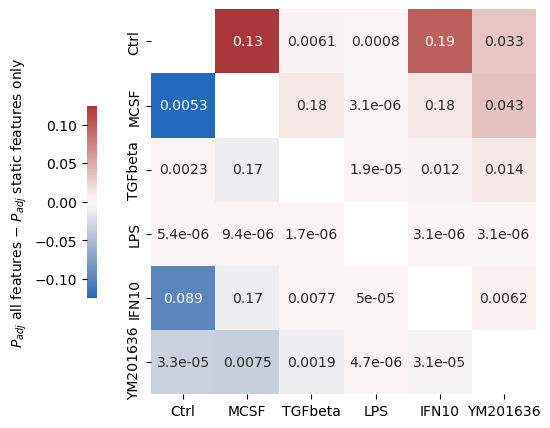

In [12]:
f = plt.figure(figsize=(7, 5))
sns.heatmap(
    (all_features - all_features.T),
    annot=all_features,
    mask=mask,
    cmap=sns.color_palette("vlag", as_cmap=True),
    square=True,
    cbar_kws={'label': "$P_{adj}$ all features $-~P_{adj}$ static features only", 'orientation': 'vertical', "location": "left", "shrink": 0.5},
)
plt.savefig("../plots/fig5/heatmap.svg", bbox_inches="tight")

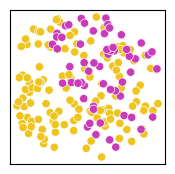

In [13]:
f = plt.figure(figsize=(2, 2))
sns.scatterplot(scatter_df, hue="Group", x="UMAP 1 all features", y="UMAP 2 all features", palette=["#EFC41C", "#CA3AB9"], legend=False)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])
plt.savefig("../plots/fig5/all_features_umap.svg")

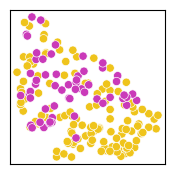

In [14]:
f = plt.figure(figsize=(2, 2))
sns.scatterplot(scatter_df, hue="Group", x="UMAP 1 static features", y="UMAP 2 static features", palette=["#EFC41C", "#CA3AB9"], legend=False)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])
plt.savefig("../plots/fig5/static_features_umap.svg")